# Computing time-resolved spectra from the NA-MD calculations 


## Table of Content: <a name="TOC"></a>

1. [Generic setups](#1)

2. [Theoretical Background](#2)

3. [Calculations](#3)

4. [Visualization](#4)


## A. Learning objectives

- to track the state's population trajectory
- to know what properties can be computed with this method



## B. Use cases

- Compute time-resolved spectra
- Compute spectra
- Read the HDF5 files to plot results of dynamical calculations

## C. Functions

- `libra_py`
  - `trpes`
    - [`compute_trpes`](#compute_trpes)
    - [`plot_trpes`](#plot_trpes)

## D. Classes and class members
    


## 1. Generic setups
<a name="1"></a>[Back to TOC](#TOC)

Here, we import all necessary libraries from the `trpes`  function and avoid showing warnings. 

In [9]:
import warnings
from libra_py import trpes
%matplotlib inline

## 2. Theoretical background
<a name="2"></a>[Back to TOC](#TOC)

Equation：
$$
smear=  \exp\left(-\frac{(e_j - e)^2}{2\sigma_e^2}\right)
$$
- **Definition**：Smoothing in the energy dimension so that the signal at each energy point is affected by the surrounding energy points simulates the finite energy resolution of the detector.
- **code correspondence**：
  ```python
smear = np.exp(-(e_j - e) ** 2) / (2 * sigma_e ** 2)
  ```
  `sigma_energy` : control of smoothing, `e_j`: Current energy grid point (e_grid), `e` : Energy of the current electronic state (in eV).


## 3. Calculations
<a name="3"></a>[Back to TOC](#TOC)

To get the calculations going, we first need to load the files. First, let's unpack the provided archive with the data provided:
Excitation energy data

In [15]:
! tar -xjf SD_basis_1.tar.bz2

and NA-MD data

In [ ]:
! tar -xjf MSDM.tar.bz2

Next, we can read in all the files usin `trpes` function:

Some key parameters:

<a name="compute_trpes"></a>

In [10]:
help(trpes.compute_trpes)

Help on function compute_trpes in module libra_py.trpes:

compute_trpes(_params)
    Args:
        params (dict): control parameters. Can contain keywords:
    
        - istep (int): the first timestep to read [default: 1]
        - fstep (int): the last timestep to read [default: 10]
        - eprefix (string): the common prefix of the energy files to read [default: "Hvib_ci_"]
        - esuffix (string): the common suffix of the energy files to read [default: "_re"]        
        - dprefix (string): the common prefix of all the dynamics simulation results (the .hdf file) [default: "icond_"]
        - dsuffix (string): the common prefix of all the dynamics simulation results (the .hdf file) [default: "/mem_data.hdf"]
        - iconds (list of ints): the beginning timesteps for all the separate simulations [default: [1] ]
        - de ( float ): spacing of the energy grid points [default: 0.01, units: eV]
        - emin ( float ): minmal energy of the range [default: 0.0, units: eV]

In [11]:
x = {"istep": 1, "fstep": 1772, 
     "eprefix":"SD_basis_1/Hvib_sd_", "esuffix":"_re",
     "iconds":[1, 201, 401, 601, 801, 1001], "dprefix":"MSDM/MSDM_new66_icond_",
     "dsuffix":"/mem_data.hdf",
     "de":0.1, "emin":2.0, "emax":4.0, "sigma_e":0.5
    }
time_bins, energy_grid, H_total = trpes.compute_trpes(x)

{'istep': 1, 'fstep': 1772, 'eprefix': 'SD_basis_1/Hvib_sd_', 'esuffix': '_re', 'iconds': [1, 201, 401, 601, 801, 1001], 'dprefix': 'MSDM/MSDM_new66_icond_', 'dsuffix': '/mem_data.hdf', 'de': 0.1, 'emin': 2.0, 'emax': 4.0, 'sigma_e': 0.5}
Reading the file MSDM/MSDM_new66_icond_1/mem_data.hdf
Reading the file MSDM/MSDM_new66_icond_201/mem_data.hdf
Reading the file MSDM/MSDM_new66_icond_401/mem_data.hdf
Reading the file MSDM/MSDM_new66_icond_601/mem_data.hdf
Reading the file MSDM/MSDM_new66_icond_801/mem_data.hdf
Reading the file MSDM/MSDM_new66_icond_1001/mem_data.hdf


In [12]:
help(trpes.plot_trpes)

Help on function plot_trpes in module libra_py.trpes:

plot_trpes(t_grid, e_grid, trpes, _plt_params)
    Args:
        t_grid ( np.array(nsteps)) : time grid [units: no units]
        e_grid ( np.array(n_e_grid_pts) ): energy grid [units: eV]
        trpes ( np.array(nsteps, n_e_grid_pts)) : TRPES - time-resolved potential energy surface
        plt_params (dict): control parameters. Can contain keywords:
        
        - fig_size ( [2-ints list]): aspect ratio and size of the figure [ default: [8,3] ] 
        - cmap_name ( string ): name of the color map [ default: "rainbow" ]
        - cfont_size ( int ): size of the fonts of the color bar [ default: 20 ]
        - ctick_size ( int ): size of the labels for the color bar tics [ default: 16 ]
        - xlabel_size ( int ): font size for the x label [ default: 20 ]
        - xtick_size ( int ): font size for the x ticks [ default: 16]
        - ylabel_size ( int ): font size for the y label [ default: 20 ]
        - ytick_size ( in

## 4. Visualization
<a name="4"></a>[Back to TOC](#TOC)

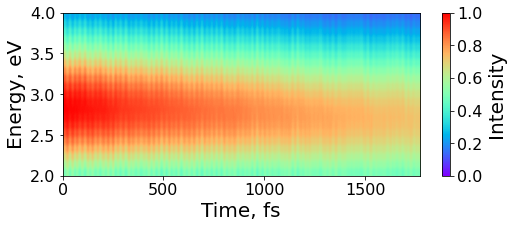

In [13]:
trpes.plot_trpes(time_bins, energy_grid, H_total, { } )

More examples of visual color schemes:

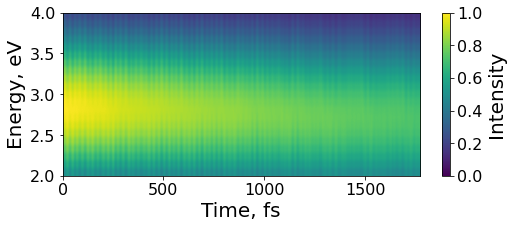

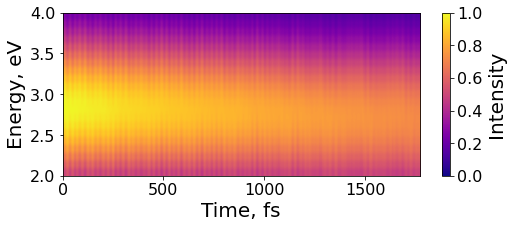

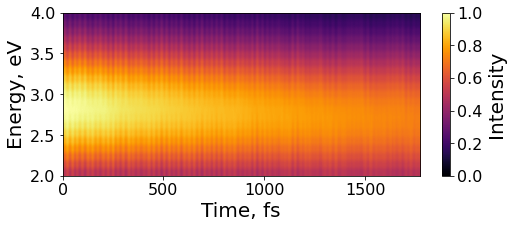

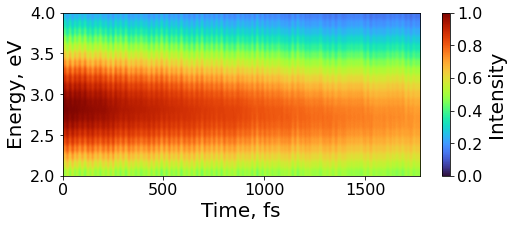

In [14]:
warnings.filterwarnings("ignore")  # Turn off warnings

cmaps = ["viridis", "plasma", "inferno", "turbo"]

# Uniform definition of parameters to prevent warnings caused by missing default parameters
params = {
    "do_show": False,  
    "do_save": False,  
    "time_units": "fs",
    "energy_units": "eV",
    "fig_size": [8, 3],
    "cfont_size": 20,
    "ctick_size": 16,
    "xlabel_size": 20,
    "xtick_size": 16,
    "ylabel_size": 20,
    "ytick_size": 16,
    "figurename": "trpes.png",
    "dpi": 300
}

for cmap in cmaps:
    params["cmap_name"] = cmap  
    trpes.plot_trpes(time_bins, energy_grid, H_total, params)  